# **주가 시계열 분석**
------------------------------
시계열 분석을 통해 주가를 예측해보겠습니다. box-jenkins방법을 이용해 분석해보겠습니다. box-jenkins 방법이란 아래와 같은 5단계를 거처 분석을 하는 방법을 말합니다. 

------
> **1. Data Transformation: 시계열 도표를 그려 시계열의 안정성을 확인, 불안정하다면 시계열 안정화(차분, 로그변환, 계절변동제거 등)  
> 2. Identification: 시계열이 안정화 된것으로 판단되면 ACF,PCAF를 그려 적합한 모형과 적절한 차수를 선정  
> 3. Estimation & Selection: 선택한 모형들의 계수 추정 후 정보기준을 이용하여 모델 선택  
> 4. Diagnostic Checking: 추정된 모형의 오챃항이 백색잡음(white noise)인지 확인  
> 5. Forecasting : 최종선택된 모형으로 예측** 


------
## **데이터 생성**

- 함수가 적힌 노트북을 실행한 뒤 예측을 위한 데이터를 생성합니다.

In [180]:
%run stock_func.ipynb
%matplotlib inline

In [181]:
code = get_code('삼성전자') #종목코드 불러오기

삼성전자 : 005930


### 삼성전자의 2018년 ~ 2019년 주가 데이터

In [267]:
start = datetime.datetime(2018,1,1)
end   = datetime.datetime(2019,12,31)
df = fdr.DataReader(code, start, end)
df_copy = df.copy()
df.head(20)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.001177
2018-01-03,52540,52560,51420,51620,200270,0.011760
2018-01-04,52120,52180,50640,51080,233909,-0.010461
2018-01-05,51300,52120,51200,52120,189623,0.020360
2018-01-08,52400,52520,51500,52020,167673,-0.001919
2018-01-09,51460,51720,49980,50400,360272,-0.031142
2018-01-10,50500,50520,48640,48840,371336,-0.030952
2018-01-11,48200,49260,48020,48240,502476,-0.012285
2018-01-12,48240,48480,46760,48200,545409,-0.000829


### 결측치 확인

In [183]:
df.isnull().sum() #없음

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64

## **Box-Jenkins Method**
--------------------
## **1. Data Transformation**
----------------
- 시계열의 안정성을 검정하기 위해 test_stationary함수를 사용합니다. 함수에 대한 설명은 stock_func.ipynb에 적어놓았습니다.

### **시계열 분해** 

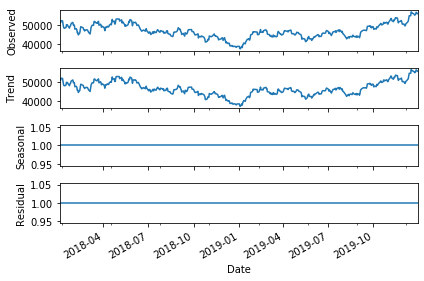

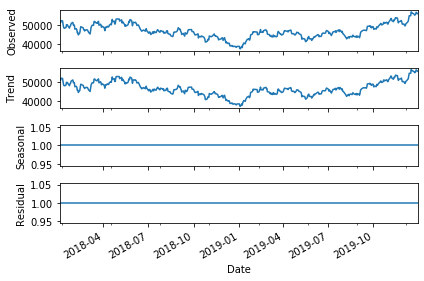

In [184]:
result = seasonal_decompose(df['Close'], model='multiplicative',freq = True)
result.plot()

- 추세는 일정하지 않고 계절 변동과 오차변동은 없어 보인다.
------
### **안정성 검정**

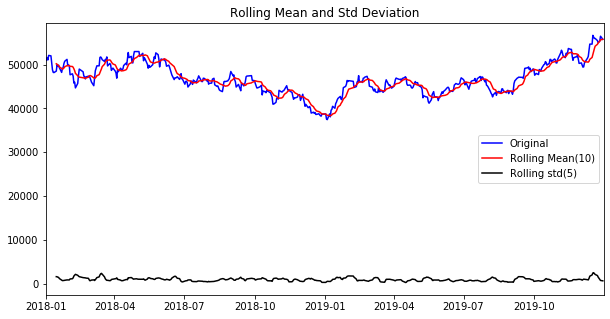

ADF Test result
Test Statistic                  -1.722921
p-value                          0.419343
#Lags Used                       0.000000
Number of Observations Used    489.000000
Critical Value (1%)             -3.443794
Critical Value (5%)             -2.867469
Critical Value (10%)            -2.569928
dtype: float64
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.716
P-value                         0.423
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [185]:
test_stationarity(df['Close'])

-----------------
원시 시계열분포의 안정성 검정을 해본결과 확장된 DF 검정과 pp 검정의 p-value를 보면 어느 유의수준에서도 귀무가설을 기각할 수 없는것으로 확인됩니다.  이동평균선과 이동표준편차선이 요동치는 형태를 보이므로 안정성 시계열이라고 할 수 없습니다. 안정성을 확보하기 위해 log를 취해보도록 하겠습니다.

### Log transformation

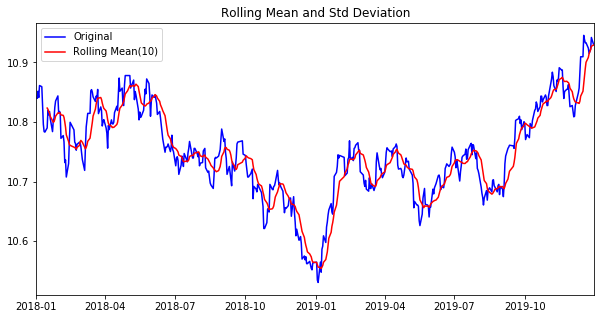

ADF Test result
Test Statistic                  -1.808053
p-value                          0.376471
#Lags Used                       0.000000
Number of Observations Used    489.000000
Critical Value (1%)             -3.443794
Critical Value (5%)             -2.867469
Critical Value (10%)            -2.569928
dtype: float64
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.845
P-value                         0.359
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [186]:
test_stationarity(np.log(df['Close']),std_plot = False)

----------
log를 취해도 위 결과와 크게 달라지지않았습니다. 아직도 불안정한 시계열임을 알수있습니다.  차분을 통해 안정성을 확보해보겠습니다.

## 차분

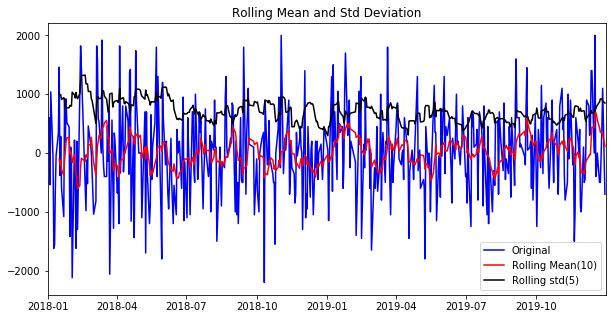

ADF Test result
Test Statistic                 -21.617657
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    488.000000
Critical Value (1%)             -3.443821
Critical Value (5%)             -2.867481
Critical Value (10%)            -2.569934
dtype: float64
     Phillips-Perron Test (Z-tau)    
Test Statistic                -21.681
P-value                         0.000
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [187]:
df['Lag'] = df['Close'].shift(1)
df['Diff1'] = df['Close'] - df['Lag']

test_stationarity(df['Diff1'].dropna()) #차분을 하게 되면 첫번째 데이터는 결측치가 된다. 따라서 결측치를 제외한채 검정을 한다.

-------
차분을 한 결과 ADF와 PP검정에서 산출된 p-value는 모두 유의수준보다 낮으므로 차분된 시계열은 안정적이라고 할수있다. 시계열의 안정성 조건은 평균, 분산 그리고 자기공분산이 일정함입니다. 

## **2. Identification**
--------------
시계열이 안정화 된것으로 판단되었으니 ACF와 PACF그래프를 그린뒤 적합한 모형의 형태(AR,MA,ARMA,ARIMA)와 적절한 차수를 선정(p,d,q)하여 후보모형군을 식별하겠습니다.

-------
### ACF, PACF
ACF(Auto Correlation Function)이란 ${y_t}$ 와 ${y_{t-j}}$사이의 자기상관계수를 말한다.   
> ${{ACF} = {{Cov({y_t},{y_{t-j}})} \over {\sqrt{Var({y_t})}{\sqrt{Var(y_{t-j})}}}}}$  
 
PACF(Partial ACF)란 ACF와 달리${y_t}$ 와 ${y_{t-j}}$ 사이 시계열의 영향력을 통제한 상관계수를 말한다.
  
> ${{PACF} = {Corr({y_t},{y_{t-j}} | {y_{t-j}},...,{y_{t-1}})}}$

---------
### 원시계열 ACF, PACF plot

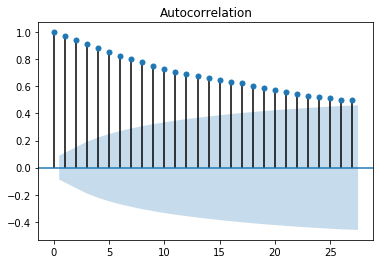

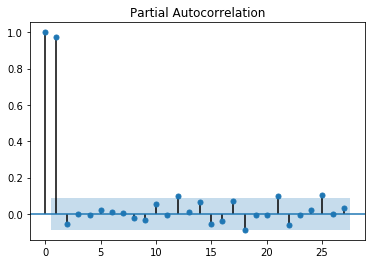

In [188]:
acf_plot(df['Close'])

------

### 차분된 시계열 ACF, PACF plot

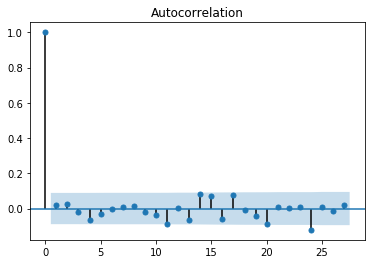

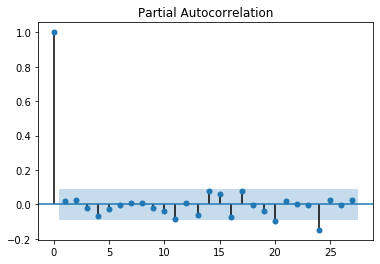

In [189]:
diff_1=df['Close'].diff(periods=1).iloc[1:] # 차분
acf_plot(diff_1)

- 원시계열의 ACF를 보면 천천히 줄어드는 모습을 보입니다. PACF를 보면 시차 1 이후에 급격히 줄어드는 모습을 보입니다. 이를 토대로 모형을 설정한다면 AR(1)모형을 설정할수 있겠습니다.  
- 1차 차분된 시계열은 ACF, PACF를 보았을때 모두 급격히 줄어드는 안정적인 모습을 보이고있습니다.

----------

# 3. Estimation & Selection

설정한 모형군을 추정한 후 정보기준을 통해 최적의 모형을 선택해 보겠습니다.

#### 참고
- ${{AIC(Akaike Informarion Criterion)} = {-2{\ln(Likelihood)} + {2k}}}$ (k는 parameter 개수)
- AIC 는 설명변수가 늘어 날수록 log likelihood에 페널티를 주는 정보기준입니다. 

---------------


## AR,MA,ARMA,ARIMA

**1. MA 모형**  
현재 시계열이 현재와 과거의 오차항에 의해서만 영향을 받는 모형입니다. 
MA(q) : ${y_t} = {\mu} +{\epsilon_{t}} + {b_1}{\epsilon_{t-1}} + + {b_2}{\epsilon_{t-2}} + ... + + {b_q}{\epsilon_{t-q}}$  

**2. AR 모형**
현재 시계열이 과거의 값에 의해서 영향을 받는 모형입니다. ar모형은 ${y_{t-p}}$를 구성하는 모든 값들이 $y_t$에 영향을 주는 모형입니다.  
AR(p) : ${y_t} = {a_0} +{\epsilon_{t}}  + {a_2}{y_{t-2}} + ... + + {a_p}{y_{t-p}+ {a_1}{y_{t-1}}}$  
**3. ARMA 모형**  
AR모형과 MA모형을 합친 형태의 모형입니다.  
**4. ARIMA 모형**  
AR + Integrated + MA 모형으로 차분된 시계열을 쌓아가면서 추정하는 모형입니다.



----------

## 모형군 설정 및 추정


----------
### AR(1) 모형 추정

 원시계열의 ACF가 천천히 줄어드는 모습, PACF는 1기 이후에 급격히 줄어드는 모습을 반영하여 AR차수를 설정한 뒤 추정을 해보았습니다.

In [190]:
df.index = pd.DatetimeIndex(df.index).to_period('D') # Valuewarning 이 발생하여 구글링 해본결과 index를 설정해주니 더이상 warning이 발생하지 않았다.

In [191]:
model = ARIMA(df['Close'], order=(1,0,0))
model_fit = model.fit(trend='nc',full_output=True, disp=1) # 상수 제외
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  490
Model:                     ARMA(1, 0)   Log Likelihood               -3935.186
Method:                       css-mle   S.D. of innovations            737.542
Date:                Sat, 08 Feb 2020   AIC                           7874.373
Time:                        23:40:32   BIC                           7882.762
Sample:                    01-02-2018   HQIC                          7877.667
                         - 12-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.Close     0.9999      0.000   7477.767      0.000       1.000       1.000
                                    Roots                                    
                  Real          Imaginary         

- AR모형의 Lag Operator계수가 p-value가 유의수준 5%보다 낮은 값을 가진다.(통계적으로 유의하다.)
- ACF,PACF그래프를 통해 차수를 결정하여 최우추정법으로 추정한 결과 정보기준(AIC)값은 7874.373입니다. 

-------
### **모형군 설정**


##### AR차수와 MA차수는 0\~2, 차분은 0\~1 로 설정하겠습니다. 차분 차수를 최대 1로 설정하는 이유는 앞서 1차 차분된 시계열이 안정적이라는 결과를 얻어냈었고, 차분을 많이 할수록 손실되는 정보가 늘어나기 때문입니다. 
-------

In [192]:
p = list(range(0, 3))
d = list(range(0, 2)) 
q = list(range(0, 3))

pdq = list(itertools.product(p, d, q))

In [193]:
for i in pdq:
    print(i)

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)


In [212]:
best_score = model_fit.aic

for orders in pdq:
    try:
        model = ARIMA(df["Close"], order=orders)
        model = model.fit(disp =0, trend= 'nc')
        print('orders : {0}, AIC : {1}'.format(orders, model.aic))
        if model.aic < best_score:
            best_score = model.aic
            best_order = orders
            
    except:
        print('orders: {0},AIC : error or unstationary'.format(orders))
        continue
        
print('=========================')
print('best_orders : {0}, best_score : {1}'.format(best_order, best_score))

orders: (0, 0, 0),AIC : error or unstationary
orders : (0, 0, 1), AIC : 11264.558737014348
orders: (0, 0, 2),AIC : error or unstationary
orders: (0, 1, 0),AIC : error or unstationary
orders : (0, 1, 1), AIC : 7849.614628623856
orders : (0, 1, 2), AIC : 7851.191559523182
orders : (1, 0, 0), AIC : 7874.3727500813675
orders: (1, 0, 1),AIC : error or unstationary
orders: (1, 0, 2),AIC : error or unstationary
orders : (1, 1, 0), AIC : 7849.605159937467
orders: (1, 1, 1),AIC : error or unstationary
orders: (1, 1, 2),AIC : error or unstationary
orders : (2, 0, 0), AIC : 7876.1861680917655
orders: (2, 0, 1),AIC : error or unstationary
orders: (2, 0, 2),AIC : error or unstationary
orders : (2, 1, 0), AIC : 7851.261422340553
orders : (2, 1, 1), AIC : 7853.228926492303
orders : (2, 1, 2), AIC : 7847.98805162434
best_orders : (2, 1, 2), best_score : 7847.98805162434


In [213]:
model = ARIMA(df['Close'], order=(2,1,2))
model_fit = model.fit(trend='nc',full_output=True, disp=1) # 상수 제외
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  489
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3918.994
Method:                       css-mle   S.D. of innovations            729.690
Date:                Sun, 09 Feb 2020   AIC                           7847.988
Time:                        00:12:11   BIC                           7868.950
Sample:                    01-03-2018   HQIC                          7856.221
                         - 12-30-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1.D.Close     0.2599      0.006     44.702      0.000       0.248       0.271
ar.L2.D.Close    -0.9978      0.005   -214.126      0.000      -1.007      -0.989
ma.L1.D.Close    -0.2498      0.011    -

----------
- ARIMA(2,1,2)모형일때 AIC값이 가장 낮게 추정되므로 이 모형을 선택하겠습니다.

------
## **4. Diagnostic Checking**

**잔차가 백색잡음(white noise)인지 확인해 봅니다. 시계열 분석에서 지켜져야되는 가정 중 하나인 "잔차의 정규성"을 확인해보겠습니다.**

-----

### **잔차(Residual)**

최종적으로 선택한 모형 \[ ARIMA(2, 1, 2) \] 의 수식은 아래와 같습니다. 

${{ARIMA(2,1,2)} : {\Delta Y_{t}} = {\alpha_{t-1}}{\Delta Y_{t-1}}+{\alpha_{t-2}}{\Delta Y_{t-2}}+{\beta_{t-1}}{\Delta \epsilon_{t-1}}+{\beta_{t-2}}{\Delta \epsilon_{t-2}} +{\epsilon_{t}}}$

${{Residual} = {\epsilon_{t}} = {\Delta Y_{t}} - ({\alpha_{t-1}}{\Delta Y_{t-1}}+{\alpha_{t-2}}{\Delta Y_{t-2}}+{\beta_{t-1}}{\Delta \epsilon_{t-1}}+{\beta_{t-2}}{\Delta \epsilon_{t-2}})}$  

실제 값에서 추정한 값을 뺀 값이 잔차입니다. 만약 어떤 모형이 좋은 모형이라면 실제값을 잘 추정하여 잔차는 더이상 추정할 수 있는 요소가 없는 상태가 될 것 입니다. 즉, 좋은 모형의 잔차는 가우시안 백색 잡음에 근사한 모습을 보입니다. 

------

### **잔차가 백색잡음인지 진단 방법** 
------
> **1. Residual Visualization**     
> **2. Shapiro-Wilk test**    
> **3. Ljung-Box test**  

2번과 3번의 경우엔 검정방법에 대해 자세히 설명하기 보다는 검정의 의미와 결과의 해석을 위주로 적어보았습니다.


-------
### 1. Residual Visualization

잔차의 분포를 시각화하여 정규분포의 모양을 띄고 있는지 확인해보겠습니다.

------

### Distplot

Text(0.5, 1.0, 'Residual plot skewness :-0.01, kurtosisness : 0.19')

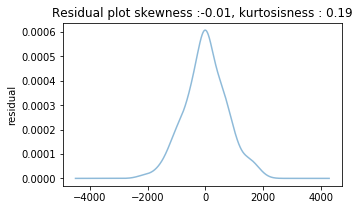

In [215]:
from scipy.stats import norm, skew, kurtosis
plt.figure(figsize = (5,3))
model_fit.resid.plot('density', alpha = 0.5)
plt.ylabel('residual')
plt.title('Residual distplot skewness :{0:.2f}, kurtosisness : {1:.2f}'.format(skew(result.resid), kurtosis(result.resid)))

- 잔차의 밀도함수를 그려보았을때 좌우 대칭의 모습을 보입니다.
- 분포의 왜도와 첨도(skewness and kurtosis)가 모두 0에 가까운 값을 가지기에 정규분포에 근사하다고 말할 수 있습니다. 

-------

### Normal QQ

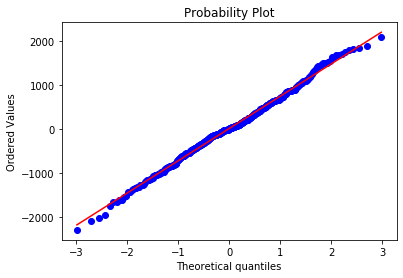

In [231]:
from scipy.stats import  probplot
probplot(model_fit.resid, dist = 'norm', plot = plt)
plt.show()

- Normal Q-Q란 자료의 분위수와 정규 분포의 분위수를 구하여 산점도로 나타낸 그림입니다.
- 점들이 45도선에 근접한 모양일수록 두 분포가 같다고 해석할 수 있습니다.
- 잔차와 정규분포의 qqplot의 모양을 보면 점들이 45도선에 모두 근접한 형태를 보입니다. 
- 따라서 잔차의 분포가 정규분포에 근사하다고 말할 수 있습니다.
--------------------------

### **2. Shapiro-Wilk test**

Shapiro-Wilk test를 알기 전에 Kolmogorov-Smirov test를 알아야합니다.   
Kolmogorov-Smirov test란  '특정 분포에서 특정 자료가 추출된다'라는 귀무가설 검정법입니다. 즉 특정 분포와 특정자료가 같은 분포인지 검정을 하는 방법입니다.  
Shapiro-Wilk test는 Kolmogorov-Smirov test에서의 특정 분포가 정규분포로 고정되어있는 검정방법입니다. 즉, 특정 자료가 정규분포에 근사한지 확인하는 방법입니다.  
Shapiro-Wilk test의 귀무가설을 기각하지 못할 경우 그 분포는 정규분포를 따른다고 말할 수 있습니다.

--------

In [232]:
from scipy.stats import shapiro

print('Shapiro Wilk test result : Stastics = {0:.3f}, P-value = {1:.3f}'.format(shapiro(model_fit.resid)[0],shapiro(model_fit.resid)[1]))

Shapiro Wilk test result : Stastics = 0.996, P-value = 0.231


- Shapiro-Wilk test 결과 p-value가 유의수준(5%) 보다 크므로 귀무가설을 기각할 수 없습니다. 
- 따라서 잔차의 분포는 정규분포를 따른다고 말할수 있습니다.

---------
### ACF plot

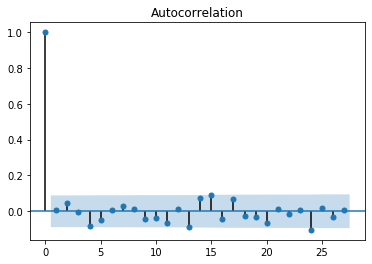

In [236]:
plot_acf(model_fit.resid)
plt.show()

- 잔차의 자기상관함수(ACF)가 모두 임계치 안에 존재하는 모습을 보입니다.
- 시각적으로는 잔차가 자기상관의 모습을 보이지않는다고 말할 수 있지만 임계치에 닿아있는듯한 모습을 보이기도 하기에 통계적 검정이 필요해보입니다.

------------
## 3. Ljung-Box test

모든 자기 상관계수의 제곱합에 대한 검정을 실시하는 검정법(box pierce test)을 보완한 검정법입니다.  
잔차의 ACF에 대해서 검정합니다. (귀무가설 : 모든 ACF가 0이다.)  


Text(0.5, 1.0, 'P-value of the Coefficient of Lag Operators')

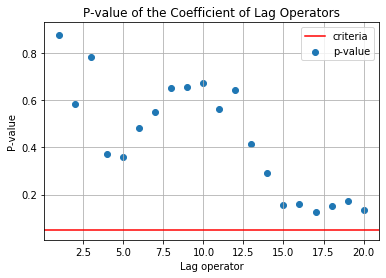

In [233]:
from statsmodels.stats.diagnostic import acorr_ljungbox

pvalues = acorr_ljungbox(model_fit.resid, lags= 20)[1]

plt.scatter(x = range(1,21),y = pvalues, label = 'p-value')
plt.axhline(y = 0.05, c = 'red', label = 'criteria') # 유의 수준
plt.grid()
plt.legend()
plt.xlabel('Lag operator')
plt.ylabel('P-value')
plt.title('P-value of the Coefficient of Lag Operators')

- 모든 Lag Opeartor 계수들의 p - value가 유의수준(5%)보다 높기 떄문에 "잔차의 자기상관계수는 모두 0이다" 라는 귀무가설을 기각할 수 없습니다. 
- 즉, 이 잔차는 백색 잡음이라고 할수 있습니다.

----------

### **결과**
**잔차에 대한 모든 진단이 잔차가 백색잡음에 부합한다고 말하고 있으므로 이 모형은 올바른 시계열 모형이라고 할수 있습니다.**

-------
## 5. Forecasting

이제 앞서 진단된 모형으로 현재 데이터와 미래 데이터에 대한 예측 성능을 알아보려 합니다.  
현재 데이터는 2018년 1월 1일 부터 2019년 12월 31일까지의 데이터 이며 미래데이터는 2020년 1월1일 부터 이 노트북을 작성하고있는 시점인 2020년 2월 6일 까지의 데이터로 설정 하겠습니다. 


-------
### Train Set Forecasting

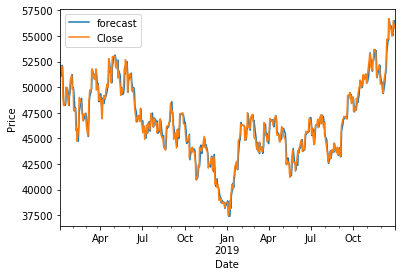

In [248]:
model_fit.plot_predict()
plt.ylabel('Price')
plt.show()

---------------------
### Test data loading

In [254]:
start_test = datetime.datetime(2020,1,1)
end_test   = datetime.datetime(2020,2,6)
test_df = fdr.DataReader(code, start_test, end_test)

test_steps = test_df.shape[0]
print('Test for {0} days'.format(test_steps))

Test for 24 days


In [255]:
fc, se, conf = model_fit.forecast(steps=test_steps, alpha=0.05)  # 95% 신뢰구간

fc_series = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)

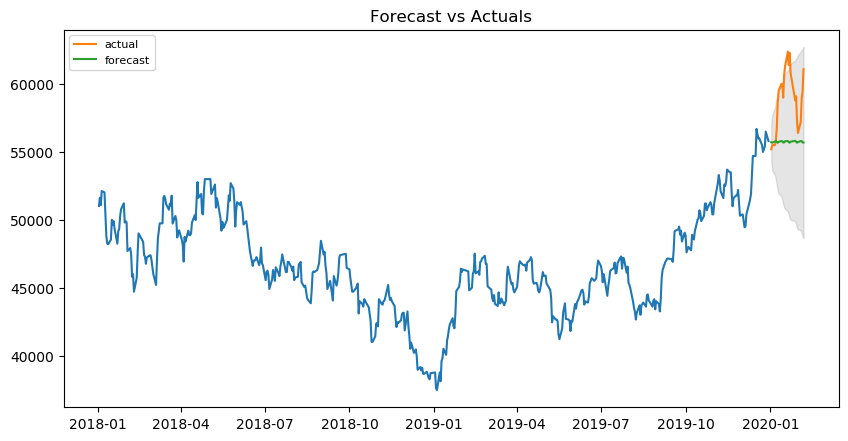

In [268]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_copy['Close'])
plt.plot(test_df['Close'], label = 'actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=0.1)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

- train set의 예측 성능에 비해 test set의 예측 성능이 매우 떨어지는 것을 확인해보았습니다. 

---------------------------------
## **마치며**

Box-Jenkins 방법을 통해 시계열 분석을 처음해보았는데 생각보다 예측성능이 안좋아 실망했습니다. 주가가 결정되는 과정엔 많은 변수들이 존재할것입니다. 복잡한 과정을 거친 주가를 과거의 값으로만 예측을 하는 시도 자체가 무리였지 않을까 싶습니다. 그래도 공부한 내용을 직접 코딩해보면서 복습해본데에서 큰 의의가 있을 것입니다. 다음 노트북에서는 주가를 예측하는데 다른 설명변수를 추가하여 예측하는 모형을 만들어 보겠습니다. 